In [1]:
from lib import helpers
import numpy as np
import tensorflow as tf
import time

## Vocab

 - Chatbot에서는 X가 질의 Y가 응답

In [2]:
x = [[5, 7, 8], [6, 3], [3], [1]] #input
xt, xlen = helpers.batch(x) #helper함수를 이용하여, 0으로 패딩 및 배치 형태로 변환
print('xt: {}'.format(xt))
print('xlen: {}'.format(xlen))

xt: [[5 6 3 1]
 [7 3 0 0]
 [8 0 0 0]]
xlen: [3, 2, 1, 1]


# Building Model

In [3]:
#모델 초기화 및 텐서플로우 interactive Session
tf.reset_default_graph()
sess = tf.InteractiveSession()

## 1. Model inputs and output

중요한 것은 vocab_size이며, Dynamic RNN 모델은 재학습 전에 batch사이즈와 Seq 길이가 다른 것을 받아들이지만, Vocab_size가 달라지면 재학습

입력과 출력에 대해서 잘 알면 끝

- `encoder_inputs` int32 tensor is shaped `[encoder_max_time, batch_size]`
- `decoder_targets` int32 tensor is shaped `[decoder_max_time, batch_size]`

We'll add one additional placeholder tensor: 
- `decoder_inputs` int32 tensor is shaped `[decoder_max_time, batch_size]`

In [4]:
PAD = 0
EOS = 1
#UNK = 3

vocab_size = 100
input_embedding_size = 32

encoder_hidden_units = 32
decoder_hidden_units = encoder_hidden_units

encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_inputs')
decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets')

#추가로 ..
decoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_inputs')

Notice that all shapes are specified with `None`s (dynamic). We can use batches of any size with any number of timesteps. This is convenient and efficient, however but there are obvious constraints: 
- Feed values for all tensors should have same `batch_size`
- Decoder inputs and ouputs (`decoder_inputs` and `decoder_targets`) should have same `decoder_max_time`

## 2. Embeddings

encoder_inputs and decoder_inputs 둘 다 int32 tensor이며 [max_time, batch_size]의 형태로 되어 있음. <br>
encoder와 decoder의 RNN은 dense vector represenation of word로 되어 있음 [max_time, batch_size, input_embedding_size] <br>
따라서, 관련 건에 대해서 word embedding 형태로 변환해야함.

1. embedding matrix 초기화 (초기화는 랜덤). 여기서는 단어의 백터표현을 인코더 - 디코더 형태의 End-to-End형식으로 표현
2. tf.nn.embedding_lookup을 활용하여 인덱싱을 한다. 4개의 단어가 있다면, 4th 열의 임베딩 메트릭스로 표현된다. 이 접근 방식은 원 핫 방식보다 연산량이 적다. Encoder와 Decoder는 임베딩을 공유한다. 실제로는 단어의 수가 몇 천개, 몇 만개로 embedding matrix가 거대해 지기 때문에 어렵다.

In [5]:
embeddings = tf.Variable(tf.random_uniform([vocab_size, input_embedding_size], -1.0, 1.0), dtype=tf.float32)

encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs)
decoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, decoder_inputs)

In [6]:
print(embeddings)
print(encoder_inputs_embedded)
print(decoder_inputs_embedded)

<tf.Variable 'Variable:0' shape=(100, 32) dtype=float32_ref>
Tensor("embedding_lookup:0", shape=(?, ?, 32), dtype=float32)
Tensor("embedding_lookup_1:0", shape=(?, ?, 32), dtype=float32)


## 3. Encoder

 - LSTM과 dynamic rnn을 활용하여 인코더를 만든다. encoder_ouputs은 seq2seq framework에는 사용할 필요가 없어 삭제한다.
 - encoder_final_state를 활용: 마지막에 encoder roll out 때, LSTM의 hidden cell state 필요 <br>
    -> encoder_final_state는 또한, "thought vector"라고 불리우는데, Decoder의 initial state로 반영 됨 <br>
    -> 이 모델은 simple 모델이므로, attention이 반영되어 있지 않기 때문에, 유일하게 Decoder로 가는 구간임. BPTT 진행 할 때 업데이트

In [7]:
with tf.variable_scope("encoder") as scope:
    #encoder_cell = tf.contrib.rnn.LSTMCell(encoder_hidden_units) #기본모델
    encoder_cell = tf.contrib.rnn.LayerNormBasicLSTMCell(encoder_hidden_units) #Layer Normalization 추가
   
    encoder_outputs, encoder_final_state = tf.nn.dynamic_rnn(
        encoder_cell, encoder_inputs_embedded,
        dtype=tf.float32, time_major=True)
    
    del encoder_outputs

In [8]:
print(encoder_final_state)

LSTMStateTuple(c=<tf.Tensor 'encoder/rnn/while/Exit_2:0' shape=(?, 32) dtype=float32>, h=<tf.Tensor 'encoder/rnn/while/Exit_3:0' shape=(?, 32) dtype=float32>)


## 4. Decoder

 - encoder_final_state가 initial_state의 decoder로 들어가므로, compatiable해야함. 같은 Cell (LSTMCell)과 같은 hidden_units (20), 같은 layers (single layers)가 맞아야함.
 - encoder에서는 cells output에 관심이 없지만, decoder output은 실제 결과 Seq를 구하기 위하여 분포를 구하는 것이라 필요함.
 - decoder_cell의 output은 hidden_units의 사이즈이지만, 학습과 예측을 위해서 vocab_size의 logits이 필요함.<br>
   -> projection layer라고 임시로 이름을 붙이는 이 레이어는, LSTM 출력 최상단에 위치 해 있음 (linear layer, no activation)

In [9]:
with tf.variable_scope("decoder") as scope:
    #decoder_cell = tf.contrib.rnn.LSTMCell(decoder_hidden_units) #Layernorm 추가
    decoder_cell = tf.contrib.rnn.LayerNormBasicLSTMCell(decoder_hidden_units) #Layernorm 추가
    
    decoder_outputs, decoder_final_state = tf.nn.dynamic_rnn(
        decoder_cell, decoder_inputs_embedded,
        initial_state = encoder_final_state,
        dtype=tf.float32, time_major=True, scope='plain_decoder')

In [10]:
print(decoder_cell)
print(decoder_outputs)
print(decoder_final_state)

Tensor("decoder/plain_decoder/TensorArrayStack/TensorArrayGatherV3:0", shape=(?, ?, 32), dtype=float32)
LSTMStateTuple(c=<tf.Tensor 'decoder/plain_decoder/while/Exit_2:0' shape=(?, 32) dtype=float32>, h=<tf.Tensor 'decoder/plain_decoder/while/Exit_3:0' shape=(?, 32) dtype=float32>)


In [11]:
decoder_logits = tf.contrib.layers.linear(decoder_outputs, vocab_size)

decoder_prediction = tf.argmax(decoder_logits, 2)

In [12]:
print(decoder_logits)
print(decoder_prediction)

Tensor("fully_connected/BiasAdd:0", shape=(?, ?, 100), dtype=float32)
Tensor("ArgMax:0", shape=(?, ?), dtype=int64)


## 5. Optimizer

 - RNN ouput tensor of shape [max_time, batch_size, hidden_units] 는 protection layer의 [max_time, batch_size, vocab_size]에 맵핑 됨. vocab_size는 static이고, max_time과 batch_size는 dynamic이다.

In [13]:
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits,
)

loss = tf.reduce_mean(stepwise_cross_entropy, name="loss")
train_op = tf.train.AdamOptimizer().minimize(loss)

In [14]:
#visualize a scalar
with tf.name_scope('loss'):
    tf.summary.scalar('loss', loss)

In [15]:
print(stepwise_cross_entropy)
print(loss)
print(train_op)

Tensor("Reshape_2:0", shape=(?, ?), dtype=float32)
Tensor("loss:0", shape=(), dtype=float32)
name: "Adam"
op: "NoOp"
input: "^Adam/update_Variable/group_deps"
input: "^Adam/update_encoder/rnn/layer_norm_basic_lstm_cell/kernel/ApplyAdam"
input: "^Adam/update_encoder/rnn/layer_norm_basic_lstm_cell/input/gamma/ApplyAdam"
input: "^Adam/update_encoder/rnn/layer_norm_basic_lstm_cell/input/beta/ApplyAdam"
input: "^Adam/update_encoder/rnn/layer_norm_basic_lstm_cell/transform/gamma/ApplyAdam"
input: "^Adam/update_encoder/rnn/layer_norm_basic_lstm_cell/transform/beta/ApplyAdam"
input: "^Adam/update_encoder/rnn/layer_norm_basic_lstm_cell/forget/gamma/ApplyAdam"
input: "^Adam/update_encoder/rnn/layer_norm_basic_lstm_cell/forget/beta/ApplyAdam"
input: "^Adam/update_encoder/rnn/layer_norm_basic_lstm_cell/output/gamma/ApplyAdam"
input: "^Adam/update_encoder/rnn/layer_norm_basic_lstm_cell/output/beta/ApplyAdam"
input: "^Adam/update_encoder/rnn/layer_norm_basic_lstm_cell/state/gamma/ApplyAdam"
input: "

In [16]:
#Tensorboard
summary_op = tf.summary.merge_all() #operation 전부 융합하기

In [17]:
sess.run(tf.global_variables_initializer())

# Test foward pass

 - Shape가 중요함. Static shape가 맞지 않으면 에러로 나옴. 하지만 dynamic shapes로 지정하였기 때문에, 실행 해보면서 체크 해야한다.

this is key part where everything comes together

@TODO: describe
- how encoder shape is fixed to max
- how decoder shape is arbitraty and determined by inputs, but should probably be longer then encoder's
- how decoder input values are also arbitraty, and how we use GO token, and what are those 0s, and what can be used instead (shifted gold sequence, beam search)

@TODO: add references

In [18]:
batch_ = [[6], [3, 4], [9, 8, 7]]

batch_, batch_length_ = helpers.batch(batch_)
print('batch_encoded:\n' + str(batch_))

din_, dlen_ = helpers.batch(np.ones(shape=(3, 1), dtype=np.int32),
                            max_sequence_length=4)
print('decoder inputs:\n' + str(din_))

pred_ = sess.run(decoder_prediction,
    feed_dict={
        encoder_inputs: batch_,
        decoder_inputs: din_,
    })
print('decoder predictions:\n' + str(pred_))

batch_encoded:
[[6 3 9]
 [0 4 8]
 [0 0 7]]
decoder inputs:
[[1 1 1]
 [0 0 0]
 [0 0 0]
 [0 0 0]]
decoder predictions:
[[99 28 27]
 [46 81 95]
 [46 81 41]
 [46 81 41]]


# Training on the toy task

 - 입력 순서를 기억하고 재생산하도록 학습시킬 것이다. 현재는 어떤 패턴도 가지고 있지 않기 때문에, 그냥 인코딩 및 디코딩만 진행 할 것이다.

In [19]:
batch_size = 100

batches = helpers.random_sequences(length_from=3, length_to=8,
                                   vocab_lower=2, vocab_upper=64,
                                   batch_size=batch_size)

print('head of the batch:')
for seq in next(batches)[:10]:
    print(seq)

head of the batch:
[26, 16, 44, 33, 3]
[29, 44, 7, 2, 56, 8, 19, 2]
[22, 35, 25]
[52, 50, 40, 47, 11]
[47, 43, 57, 18, 35]
[16, 24, 7, 41, 44, 58, 21, 50]
[6, 35, 6, 22]
[22, 55, 23, 36, 15, 4, 3, 36]
[10, 58, 14, 51, 36, 53, 38]
[60, 47, 38]


In [20]:
def next_feed():
    batch = next(batches)
    encoder_inputs_, _ = helpers.batch(batch)
    decoder_targets_, _ = helpers.batch(
        [(sequence) + [EOS] for sequence in batch]
    )
    decoder_inputs_, _ = helpers.batch(
        [[EOS] + (sequence) for sequence in batch]
    )
    return {
        encoder_inputs: encoder_inputs_,
        decoder_inputs: decoder_inputs_,
        decoder_targets: decoder_targets_,
    }

In [21]:
loss_track = []

In [22]:
max_batches = 3001
batches_in_epoch = 1000

try:
    for batch in range(max_batches):
        fd = next_feed()
        #_, l, summary = sess.run([train_op, loss, summary_op], fd)
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)
        
        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(decoder_prediction, fd)
            for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 2:
                    break
            print()
        
        #Tensorboard
        #log_writer = tf.summary.FileWriter('tensorboard')
        #log_writer.add_summary(summary, batch)
        #time.sleep(0.5)
        
except KeyboardInterrupt:
    print('training interrupted')

batch 0
  minibatch loss: 4.671084403991699
  sample 1:
    input     > [48 16 19 46  0  0  0  0]
    predicted > [70 88 88 88 88 46 84 40 40]
  sample 2:
    input     > [24 58  5 14  0  0  0  0]
    predicted > [99 46 46 46 46 46 46 46 46]
  sample 3:
    input     > [34 15 58 12 63 32  0  0]
    predicted > [ 0 82 54  9 54 65 21 46 41]

batch 1000
  minibatch loss: 1.1468178033828735
  sample 1:
    input     > [33  3 53 48 51  2 63 18]
    predicted > [33  3 48 51 18 18 18 18  1]
  sample 2:
    input     > [ 3 42  4  5 11 33  0  0]
    predicted > [ 3  5 44  5 11 33  1  0  0]
  sample 3:
    input     > [38 38  4  0  0  0  0  0]
    predicted > [38 38  4  1  0  0  0  0  0]

batch 2000
  minibatch loss: 0.36455798149108887
  sample 1:
    input     > [18 17 62  9 61 39  0  0]
    predicted > [18 17 62  9 61 39  1  0  0]
  sample 2:
    input     > [43 63 22  0  0  0  0  0]
    predicted > [43 63 22  1  0  0  0  0  0]
  sample 3:
    input     > [58 18 41  0  0  0  0  0]
    predict

# Layernorm 그래프

loss 0.2658 after 300100 examples (batch_size=100)


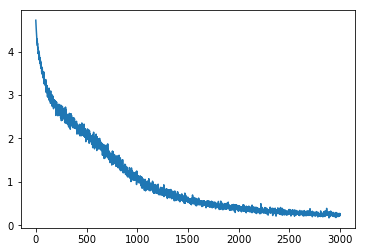

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))

In [ ]:
tf.summarytf.summary

# 간단한 Simple seq2seq의 한계

We have no control over transitions of `tf.nn.dynamic_rnn`, it is unrolled in a single sweep. Some of the things that are not possible without such control:

- We can't feed previously generated tokens without falling back to Python loops. This means *we cannot make efficient inference with dynamic_rnn decoder*!

- We can't use attention, because attention conditions decoder inputs on its previous state

Solution would be to use `tf.nn.raw_rnn` instead of `tf.nn.dynamic_rnn` for decoder, as we will do in tutorial #2. 